# **Datasets Analysis :** PointMaze

See the [gymnasium documentation](https://robotics.farama.org/envs/maze/point_maze/) for more information on this environment.

**MAZES :** `UMaze` , `Medium` , `Large`

**TASKS :** 
- *Default* : `normal`
- *Topological Changes* : `shift_map_1` , `shift_map_2` , `rescale_map_1` , `rescale_map_2`
- *Kinematic Changes* : `inverse_actions` , `permute_actions` ,  `rescale_actions_1` , `rescale_actions_2`

___
___

### **A. Environments**

<table>
<tr>
<tr>
<th style="padding: 25px;">UMaze<br><br><img src="../../../../assets/environments/gym_goal/pointmaze/pointmaze_umaze.gif" alt="PointMaze Umaze" style="height: 400px;"/><br><br></th>
<th style="padding: 25px;">UMaze<br><br><img src="../../../../assets/environments/gym_goal/pointmaze/pointmaze_medium.gif" alt="PointMaze Medium" style="height: 400px;"/><br><br></th>
<th style="padding: 25px;">UMaze<br><br><img src="../../../../assets/environments/gym_goal/pointmaze/pointmaze_large.gif" alt="PointMaze Large" style="height: 400px;"/><br><br></th>
</tr>
</table>
</tr>
</table>

___
___

### **B. Data**

In [6]:
from offbench.data.episodes_db import GymGoalEpisodesDB
from offbench.utils.paths import OFFBENCH_PATH
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch

In [7]:
seed = 0

n_episodes = [10, 50, 125, 250, 500, 1000]

assets_dir_path = os.path.join(OFFBENCH_PATH, "assets", "environments", "gym_goal", "pointmaze")

tasks = [
    "UMaze",
    "Medium",
    "Large"
]

task_to_env = {
    "UMaze": "pointmaze-umaze-normal",
    "Medium": "pointmaze-medium-normal",
    "Large": "pointmaze-large-normal"
}

task_to_background_paths = {
    "UMaze": os.path.join(assets_dir_path, "maze_umaze.png"),
    "Medium": os.path.join(assets_dir_path, "maze_medium.png"),
    "Large": os.path.join(assets_dir_path, "maze_large.png")
}

task_to_dataset = {
    "UMaze": GymGoalEpisodesDB(task_to_env["UMaze"]),
    "Medium": GymGoalEpisodesDB(task_to_env["Medium"]),
    "Large": GymGoalEpisodesDB(task_to_env["Large"])
}

___

### **C. Trajectories Visualization**


N Episodes = 10 / Seed = 0


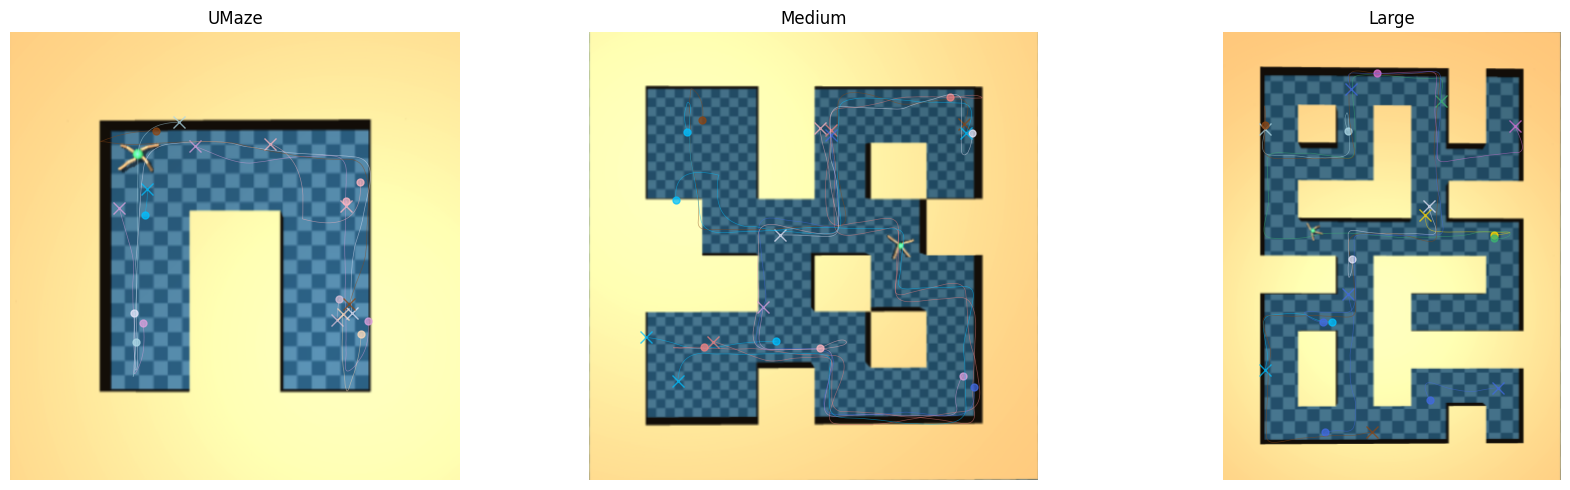


N Episodes = 50 / Seed = 0


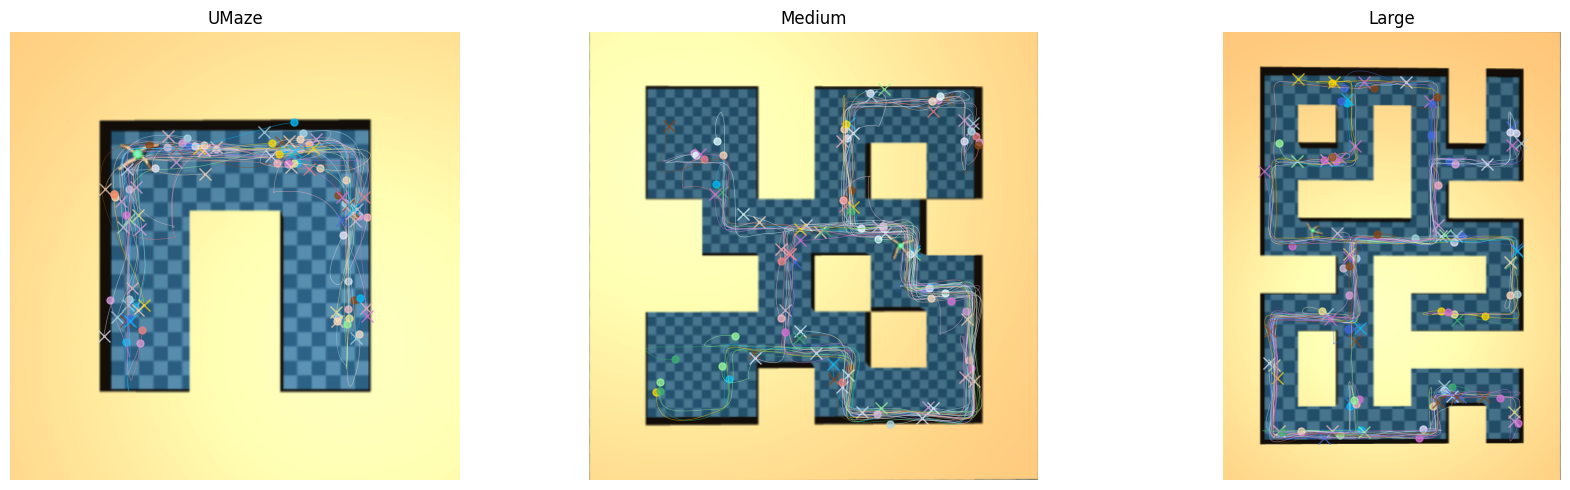


N Episodes = 125 / Seed = 0


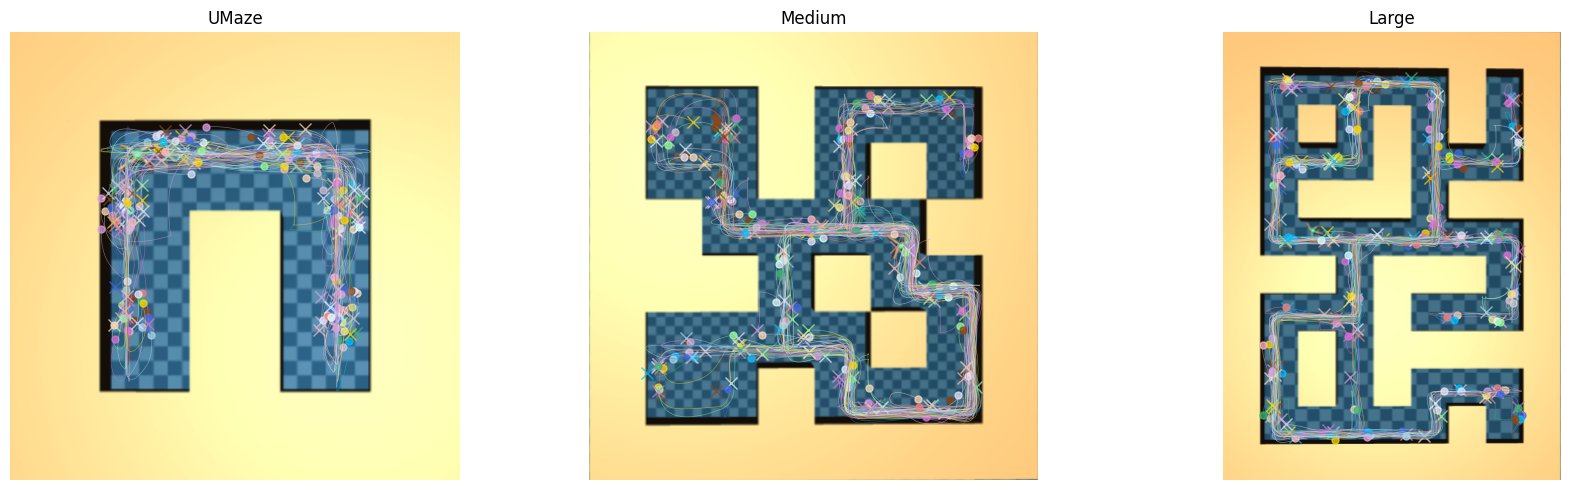


N Episodes = 250 / Seed = 0


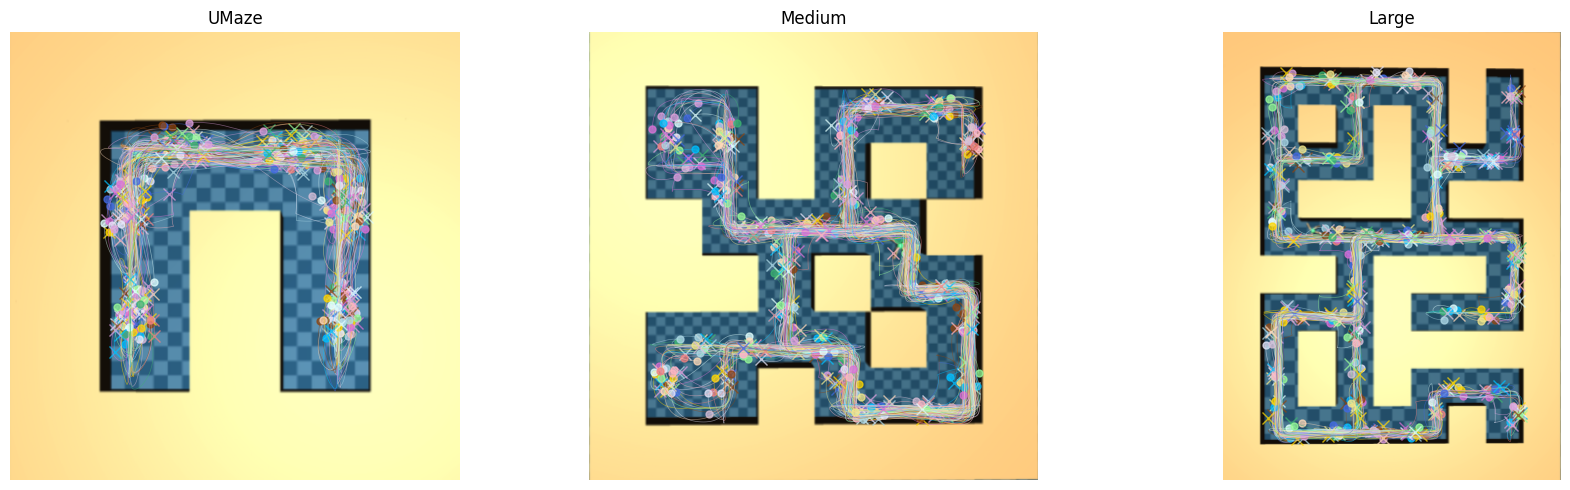


N Episodes = 500 / Seed = 0


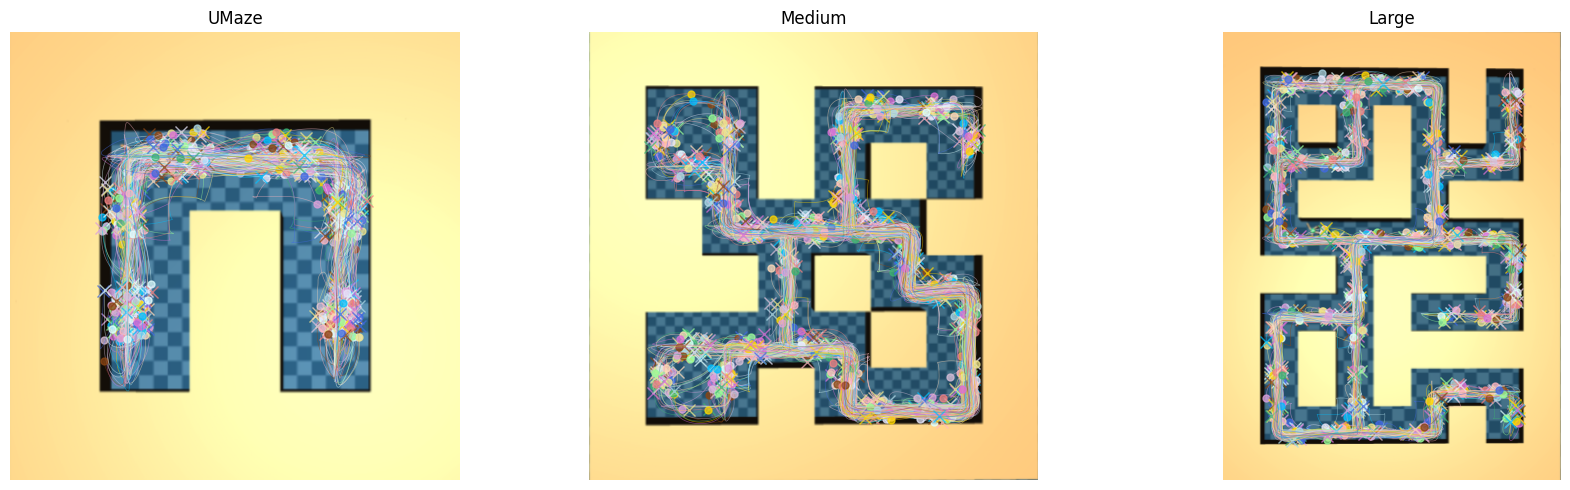


N Episodes = 1000 / Seed = 0


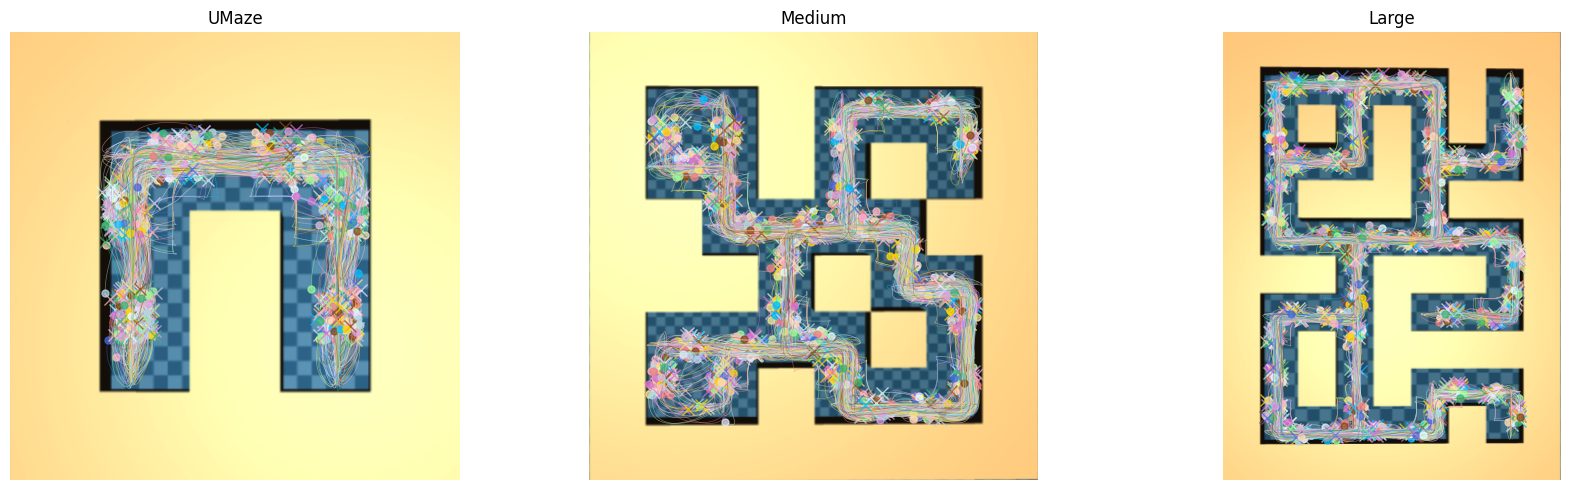

In [8]:
colors = [
    "gold", "palegreen", "deepskyblue", "lavender", "mediumseagreen", 
    "royalblue", "orchid", "saddlebrown", "lightcoral", "khaki", 
    "lightblue", "plum", "lightpink", "peachpuff", "lightcyan", "thistle"
]

# to adjust the plot limits depending on the task
task_to_adjustments = {
    "UMaze": [0.6, 0.6],
    "Medium": [0.75, 0.75],
    "Large": [0.77, 0.83]
}

for n_episode in n_episodes:

    # it will store the trajectories for each task and the corresponding colors
    task_to_trajectories:Dict[str,Dict[str,torch.Tensor]] = {}
    task_to_trajectories_colors:Dict[str,Dict[str,int]] = {}

    for task,dataset in task_to_dataset.items():
        
        # we just keep the first n_episode trajectories
        ids = dataset.get_ids()
        np.random.seed(seed)
        np.random.shuffle(ids)
        ids = ids[:n_episode]

        # we get the trajectories
        trajectories = {idx: dataset[idx].to_dict()["observation/pos"][0][:,[1,0]] for idx in ids}

        for idx,xy in trajectories.items():
            trajectories[idx] = - xy

        # random color for each trajectory
        trajectories_colors = {idx: np.random.randint(0,len(colors)) for idx in trajectories}
        
        # we store the trajectories and the corresponding colors for the task
        task_to_trajectories[task] = trajectories
        task_to_trajectories_colors[task] = trajectories_colors

    # we set the figure
    fig, axs = plt.subplots(ncols=3, figsize=(18,5))
    print("\nN Episodes = {} / Seed = {}".format(n_episode,seed))

    x_mins, y_mins, x_maxs, y_maxs = {}, {}, {}, {}

    for task in tasks:
        x_mins[task] = np.min([torch.min(xy[:,0]).item() for _,xy in task_to_trajectories[task].items()])
        x_maxs[task] = np.max([torch.max(xy[:,0]).item() for _,xy in task_to_trajectories[task].items()])
        y_mins[task] = np.min([torch.min(xy[:,1]).item() for _,xy in task_to_trajectories[task].items()])
        y_maxs[task] = np.max([torch.max(xy[:,1]).item() for _,xy in task_to_trajectories[task].items()])

    for i,task in enumerate(tasks):

        # get the trajectories
        trajectories = task_to_trajectories[task]
        trajectories_colors = task_to_trajectories_colors[task]

        # remove spines
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)

        # plot trajectories in the corresponding subplot
        axs[i].set_title(task)

        # set the background image
        background = plt.imread(task_to_background_paths[task])
        axs[i].imshow(background)

        x_min = x_mins[task]
        x_max = x_maxs[task]
        y_min = y_mins[task]
        y_max = y_maxs[task]

        for idx in trajectories:

            xy = trajectories[idx]

            tx = task_to_adjustments[task][0]
            ty = task_to_adjustments[task][1]

            x_rescaled = (xy[:,0] - x_min) / (x_max - x_min) * background.shape[1] * tx + 0.5 * background.shape[1] * (1 - tx)
            y_rescaled = (xy[:,1] - y_min) / (y_max - y_min) * background.shape[0] * ty + 0.5 * background.shape[0] * (1 - ty)

            color = colors[trajectories_colors[idx]]

            # plot the trajectory
            axs[i].plot(x_rescaled, y_rescaled, color = color, linewidth = 0.5, alpha=0.5)

            # plot circle at the beginning
            axs[i].plot(x_rescaled[0], y_rescaled[0], 'o', color = color, markersize=5, alpha=0.75)

            # plot cross at the end
            axs[i].plot(x_rescaled[-1], y_rescaled[-1], 'x', color = color, markersize=9, alpha=0.75)

        # hide xticks and yticks
        axs[i].set_xticks([])
        axs[i].set_yticks([])

    # space between subplots
    plt.subplots_adjust(wspace=0.1,hspace=0)
    plt.tight_layout()

    # save the plot
    plt.savefig("./plots/trajectories_N{}_S{}.png".format(n_episode,seed),transparent=True)
    plt.savefig("./plots/trajectories_N{}_S{}_alt.png".format(n_episode,seed),transparent=False)

    # show the plot
    plt.show()

___

### **C. Metrics**

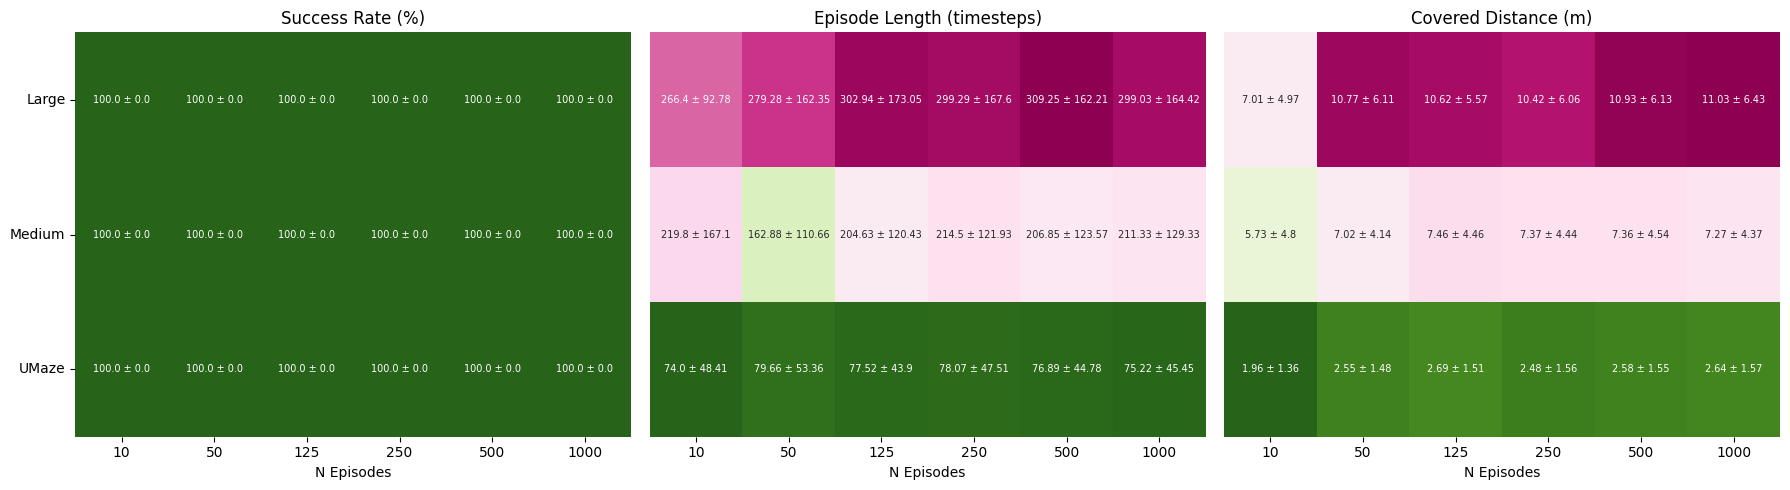

In [11]:
metrics = {
    "metric": [],
    "n_episode": [],
    "task": [],
    "value": [],
}

for n_episode in n_episodes:

    # AVG SUCCESS
    avg_success = []
    for task,dataset in task_to_dataset.items():
        successes = []
        ids = dataset.get_ids()
        np.random.seed(seed)
        np.random.shuffle(ids)
        ids = ids[:n_episode]
        for idx in ids: successes.append(100 * dataset[idx].to_dict()["done"][0,-1].float().item())
        metrics["metric"].extend(["avg_success"] * len(successes))
        metrics["n_episode"].extend([n_episode] * len(successes))
        metrics["task"].extend([task] * len(successes))
        metrics["value"].extend(successes)

    # AVG LENGTHS
    avg_lengths = []
    for task,dataset in task_to_dataset.items():
        lengths = []
        ids = dataset.get_ids()
        np.random.seed(seed)
        np.random.shuffle(ids)
        ids = ids[:n_episode]
        for idx in ids: lengths.append(len(dataset[idx].to_dict()["observation/pos"][0]))
        metrics["metric"].extend(["avg_length"] * len(lengths))
        metrics["n_episode"].extend([n_episode] * len(lengths))
        metrics["task"].extend([task] * len(lengths))
        metrics["value"].extend(lengths)

    # AVG DISTANCES
    for task,dataset in task_to_dataset.items():
        distances = []
        ids = dataset.get_ids()
        np.random.seed(seed)
        np.random.shuffle(ids)
        ids = ids[:n_episode]
        for idx in ids:
            positions = dataset[idx].to_dict()["observation/pos"][0]
            distance = 0
            position = positions[0]
            for new_position in positions[1:]:
                distance += torch.norm(position-new_position).float().item()
                position = new_position
            distances.append(distance)
        metrics["metric"].extend(["avg_distance"] * len(distances))
        metrics["n_episode"].extend([n_episode] * len(distances))
        metrics["task"].extend([task] * len(distances))
        metrics["value"].extend(distances)

# ALL METRICS
df = pd.DataFrame(metrics)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

# reduce space between subplots
plt.subplots_adjust(wspace=0.05,hspace=0)

metric_titles = ["Success Rate (%)", "Episode Length (timesteps)", "Covered Distance (m)"]

metric_to_cmap = {
    "avg_success": "PiYG_r",
    "avg_length": "PiYG_r",
    "avg_distance": "PiYG_r",
}

for i, metric in enumerate(["avg_success", "avg_length", "avg_distance"]):

    df_metric = df[df["metric"]==metric][["n_episode", "task", "value"]]
    df_metric = df_metric.groupby(["n_episode", "task"]).agg(["mean", "std"]).reset_index()
    df_metric.columns = ['_'.join(col).rstrip('_') for col in df_metric.columns.values]

    mean_values = df_metric.pivot(index="task", columns="n_episode", values=f"value_mean")
    std_values = df_metric.pivot(index="task", columns="n_episode", values=f"value_std")

    # need to check annot generation as I get the error : ValueError: Unknown format code 'g' for object of type 'str'
    # annot should be mean_values.round(2).astype(str) + " ± " + std_values.round(2).astype(str)
    annot = mean_values.round(2).astype(str) + " ± " + std_values.round(2).astype(str)

    sns.heatmap(
        mean_values,
        ax=ax[i],
        annot=annot,
        annot_kws={"fontsize":7},
        fmt="",
        cbar=False,
        cmap=metric_to_cmap[metric],
    )

    ax[i].set_xlabel("N Episodes")
    ax[i].set_ylabel("")

    if i == 0:
        # pivot y ticks by 90
        ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation=0)

    if i > 0: ax[i].set_yticks([])

    ax[i].set_title(metric_titles[i])

# Space between subplots
plt.tight_layout()

# Save the plot
plt.savefig("./plots/metrics_S{}.png".format(seed),transparent=True)
plt.savefig("./plots/metrics_alt_S{}.png".format(seed),transparent=False)

# Show the plot
plt.show()

___
___